In [1]:
import nbformat
from nbconvert import PythonExporter

with open("5. graph_structure.ipynb", "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(notebook)

with open("5. graph_structure.py", "w", encoding="utf-8") as f:
    f.write(source)

In [2]:
import os
import pickle
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import from_networkx

In [3]:
estimator_name = 'TFT'

levels = [
    [],                             # Level 1: Total
    ['state_id'],                   # Level 2: State
    ['store_id'],                   # Level 3: Store
    ['cat_id'],                     # Level 4: Category
    ['dept_id'],                    # Level 5: Department
    ['state_id', 'cat_id'],         # Level 6: State-Category
    ['state_id', 'dept_id'],        # Level 7: State-Department
    ['store_id', 'cat_id'],         # Level 8: Store-Category
    ['store_id', 'dept_id'],        # Level 9: Store-Department
    ['item_id'],                    # Level 10: Item
    ['item_id', 'state_id'],        # Level 11: Item-State
    ['item_id', 'store_id']         # Level 12: Item-Store
]

level_to_nodes = {}
for level_idx in range(1,13):
    result_dir = '../result'
    level_dir = os.path.join(result_dir, f'level {level_idx}')
    model_dirs = [d for d in os.listdir(level_dir) if d.startswith(f'{estimator_name}_')]
    model_dir = os.path.join(level_dir, model_dirs[0])

    dfs_dir = os.path.join(model_dir, 'dfs.pkl')
    with open(dfs_dir, 'rb') as file:
        dfs = pickle.load(file)

    level_to_nodes[level_idx] = list(dfs.keys())    

all_nodes = []
node_to_idx = {}
level_to_idx = {}
for level, nodes in level_to_nodes.items():
    level_to_idx[level] = []
    for node in nodes:
        node_to_idx[node] = len(all_nodes)
        all_nodes.append(node)
        level_to_idx[level].append(node_to_idx[node])

idx_to_forecast = {}
idx_to_label = {}
for level_idx in range(1,13):
    result_dir = '../result'
    level_dir = os.path.join(result_dir, f'level {level_idx}')
    model_dirs = [d for d in os.listdir(level_dir) if d.startswith(f'{estimator_name}_')]
    model_dir = os.path.join(level_dir, model_dirs[0])

    dfs_dir = os.path.join(model_dir, 'dfs.pkl')
    with open(dfs_dir, 'rb') as file:
        dfs = pickle.load(file)

    for node in list(dfs.keys()):
        idx = node_to_idx[node]
        idx_to_forecast[idx] = torch.tensor(dfs[node]['forecast'].values[28:], dtype=torch.float)
        idx_to_label[idx] = torch.tensor(dfs[node]['label'].values[28:], dtype=torch.float)

In [4]:
# NetworkX 그래프
G = nx.DiGraph()

# 노드 추가
for i, node in enumerate(all_nodes):
    level = next((level for level, idx in level_to_idx.items() if i in idx), None)
    G.add_node(i, name=node, level=level)

In [5]:
# 엣지 추가

# 지리적 계층
if 1 in level_to_idx and 2 in level_to_idx:  # Total <-> State
    total_idx = level_to_idx[1][0]
    for state_idx in level_to_idx[2]:
        G.add_edge(total_idx, state_idx, type='geo_hierarchy', direction='down')
        G.add_edge(state_idx, total_idx, type='geo_hierarchy', direction='up')

if 2 in level_to_idx and 3 in level_to_idx:  # State <-> Store
    for state_idx in level_to_idx[2]:
        state_name = all_nodes[state_idx]
        for store_idx in level_to_idx[3]:
            store_name = all_nodes[store_idx]
            if store_name.startswith(state_name):
                G.add_edge(state_idx, store_idx, type='geo_hierarchy', direction='down')
                G.add_edge(store_idx, state_idx, type='geo_hierarchy', direction='up')

# 상품 계층
if 1 in level_to_idx and 4 in level_to_idx:  # Total <-> Category
    total_idx = level_to_idx[1][0]
    for cat_idx in level_to_idx[4]:
        G.add_edge(total_idx, cat_idx, type='prod_hierarchy', direction='down')
        G.add_edge(cat_idx, total_idx, type='prod_hierarchy', direction='up')

if 4 in level_to_idx and 5 in level_to_idx:  # Category <-> Department
    for cat_idx in level_to_idx[4]:
        cat_name = all_nodes[cat_idx]
        for dept_idx in level_to_idx[5]:
            dept_name = all_nodes[dept_idx]
            if dept_name.startswith(cat_name):
                G.add_edge(cat_idx, dept_idx, type='prod_hierarchy', direction='down')
                G.add_edge(dept_idx, cat_idx, type='prod_hierarchy', direction='up')

if 5 in level_to_idx and 10 in level_to_idx:  # Department <-> Item
    for dept_idx in level_to_idx[5]:
        dept_name = all_nodes[dept_idx]
        for item_idx in level_to_idx[10]:
            item_name = all_nodes[item_idx]
            if dept_name.startswith(item_name):
                G.add_edge(dept_idx, item_idx, type='prod_hierarchy', direction='down')
                G.add_edge(item_idx, dept_idx, type='prod_hierarchy', direction='up')

# 결합 계층
if 2 in level_to_idx and 6 in level_to_idx: # State <-> State x Category
    for state_idx in level_to_idx[2]:
        state_name = all_nodes[state_idx]
        for state_cat_idx in level_to_idx[6]:
            state_cat_name = all_nodes[state_cat_idx]
            if state_cat_name.startswith(state_name):
                G.add_edge(state_idx, state_cat_idx, type='agg_hierarchy', direction='cross')
                G.add_edge(state_cat_idx, state_idx, type='agg_hierarchy', direction='cross')

if 4 in level_to_idx and 6 in level_to_idx: # Category <-> State x Category
    for cat_idx in level_to_idx[4]:
        cat_name = all_nodes[cat_idx]
        for state_cat_idx in level_to_idx[6]:
            state_cat_name = all_nodes[state_cat_idx]
            if state_cat_name.endswith(cat_name):
                G.add_edge(cat_idx, state_cat_idx, type='agg_hierarchy', direction='down')
                G.add_edge(state_cat_idx, cat_idx, type='agg_hierarchy', direction='up')

if 2 in level_to_idx and 7 in level_to_idx: # State <-> State x Department
    for state_idx in level_to_idx[2]:
        state_name = all_nodes[state_idx]
        for state_dept_idx in level_to_idx[7]:
            state_dept_name = all_nodes[state_dept_idx]
            if state_dept_name.startswith(state_name):
                G.add_edge(state_idx, state_dept_idx, type='agg_hierarchy', direction='down')
                G.add_edge(state_dept_idx, state_idx, type='agg_hierarchy', direction='up')

if 5 in level_to_idx and 7 in level_to_idx: # Department <-> State x Department
    for dept_idx in level_to_idx[5]:
        dept_name = all_nodes[dept_idx]
        for state_dept_idx in level_to_idx[7]:
            state_dept_name = all_nodes[state_dept_idx]
            if state_dept_name.endswith(dept_name):
                G.add_edge(dept_idx, state_dept_idx, type='agg_hierarchy', direction='down')
                G.add_edge(state_dept_idx, dept_idx, type='agg_hierarchy', direction='up')

if 2 in level_to_idx and 11 in level_to_idx: # State <-> State x Item
    for state_idx in level_to_idx[2]:
        state_name = all_nodes[state_idx]
        for item_state_idx in level_to_idx[11]:
            item_state_name = all_nodes[item_state_idx]
            if item_state_name.endswith(state_name):
                G.add_edge(state_idx, item_state_idx, type='agg_hierarchy', direction='down')
                G.add_edge(item_state_idx, state_idx, type='agg_hierarchy', direction='up')

if 10 in level_to_idx and 11 in level_to_idx: # Item <-> State x Item
    for item_idx in level_to_idx[10]:
        item_name = all_nodes[item_idx]
        for item_state_idx in level_to_idx[11]:
            item_state_name = all_nodes[item_state_idx]
            if item_state_name.startswith(item_name):
                G.add_edge(item_idx, item_state_idx, type='agg_hierarchy', direction='down')
                G.add_edge(item_state_idx, item_idx, type='agg_hierarchy', direction='up')

if 3 in level_to_idx and 8 in level_to_idx: # Store <-> Store x Category
    for store_idx in level_to_idx[3]:
        store_name = all_nodes[store_idx]
        for store_cat_idx in level_to_idx[8]:
            store_cat_name = all_nodes[store_cat_idx]
            if store_cat_name.startswith(store_name):
                G.add_edge(store_idx, store_cat_idx, type='agg_hierarchy', direction='down')
                G.add_edge(store_cat_idx, store_idx, type='agg_hierarchy', direction='up')

if 4 in level_to_idx and 8 in level_to_idx: # Category <-> Store x Category
    for cat_idx in level_to_idx[4]:
        cat_name = all_nodes[cat_idx]
        for store_cat_idx in level_to_idx[8]:
            store_cat_name = all_nodes[store_cat_idx]
            if store_cat_name.endswith(cat_name):
                G.add_edge(cat_idx, store_cat_idx, type='agg_hierarchy', direction='down')
                G.add_edge(store_cat_idx, cat_idx, type='agg_hierarchy', direction='up')

if 3 in level_to_idx and 9 in level_to_idx: # Store <-> Store x Department
    for store_idx in level_to_idx[3]:
        store_name = all_nodes[store_idx]
        for store_dept_idx in level_to_idx[9]:
            store_dept_name = all_nodes[store_dept_idx]
            if store_dept_name.startswith(store_name):
                G.add_edge(store_idx, store_dept_idx, type='agg_hierarchy', direction='down')
                G.add_edge(store_dept_idx, store_idx, type='agg_hierarchy', direction='up')

if 5 in level_to_idx and 9 in level_to_idx: # Department <-> Store x Department
    for dept_idx in level_to_idx[5]:
        dept_name = all_nodes[dept_idx]
        for store_dept_idx in level_to_idx[7]:
            store_dept_name = all_nodes[store_dept_idx]
            if store_dept_name.endswith(dept_name):
                G.add_edge(dept_idx, store_dept_idx, type='agg_hierarchy', direction='down')
                G.add_edge(store_dept_idx, dept_idx, type='agg_hierarchy', direction='up')

if 3 in level_to_idx and 12 in level_to_idx: # Store <-> Store x Item
    for store_idx in level_to_idx[3]:
        store_name = all_nodes[store_idx]
        for item_store_idx in level_to_idx[12]:
            item_store_name = all_nodes[item_store_idx]
            if item_store_name.endswith(store_name):
                G.add_edge(store_idx, item_store_idx, type='agg_hierarchy', direction='down')
                G.add_edge(item_store_idx, store_idx, type='agg_hierarchy', direction='up')

if 10 in level_to_idx and 12 in level_to_idx: # Item <-> Store x Item
    for item_idx in level_to_idx[10]:
        item_name = all_nodes[item_idx]
        for item_store_idx in level_to_idx[12]:
            item_store_name = all_nodes[item_store_idx]
            if item_store_name.startswith(item_name):
                G.add_edge(item_idx, item_store_idx, type='agg_hierarchy', direction='down')
                G.add_edge(item_store_idx, item_idx, type='agg_hierarchy', direction='up')

# 크로스 계층
if 6 in level_to_idx and 7 in level_to_idx: # State x Category <-> State x Department
    for state_cat_idx in level_to_idx[6]:
        state_cat_name = all_nodes[state_cat_idx]
        for state_dept_idx in level_to_idx[7]:
            state_dept_name = all_nodes[state_dept_idx]
            if state_dept_name.startswith(state_cat_name):
                G.add_edge(state_cat_idx, state_dept_idx, type='cross_hierarchy', direction='down')
                G.add_edge(state_dept_idx, state_cat_idx, type='cross_hierarchy', direction='up')

if 7 in level_to_idx and 11 in level_to_idx: # State x Department <-> State x Item
    for state_dept_idx in level_to_idx[7]:
        state_dept_name = all_nodes[state_dept_idx]
        state_dept_parts = state_dept_name.split('_')
        state = state_dept_parts[0]
        dept = '_'.join(state_dept_parts[1:])
        for state_item_idx in level_to_idx[11]:
            state_item_name = all_nodes[state_item_idx]
            state_item_parts = state_item_name.split('_')
            item_dept = state_item_parts[0] + '_' + state_item_parts[1]
            item_state = state_item_parts[-1]
            if dept == item_dept and state == item_state:
                G.add_edge(state_dept_idx, state_item_idx, type='cross_hierarchy', direction='down')
                G.add_edge(state_item_idx, state_dept_idx, type='cross_hierarchy', direction='up')

if 8 in level_to_idx and 9 in level_to_idx: # Store x Category <-> Store x Department
    for store_cat_idx in level_to_idx[8]:
        store_cat_name = all_nodes[store_cat_idx]
        for store_dept_idx in level_to_idx[9]:
            store_dept_name = all_nodes[store_dept_idx]
            if store_dept_name.startswith(store_cat_name):
                G.add_edge(store_cat_idx, store_dept_idx, type='cross_hierarchy', direction='down')
                G.add_edge(store_dept_idx, store_cat_idx, type='cross_hierarchy', direction='up')

if 9 in level_to_idx and 12 in level_to_idx: # Store x Department <-> Store x Item
    for store_dept_idx in level_to_idx[9]:  
        store_dept_name = all_nodes[store_dept_idx]  
        store_dept_parts = store_dept_name.split('_')
        store = store_dept_parts[0] + '_' + store_dept_parts[1]     
        dept = store_dept_parts[2] + '_' + store_dept_parts[3]     
        for item_store_idx in level_to_idx[12]: 
            item_store_name = all_nodes[item_store_idx]
            item_store_parts = item_store_name.split('_')
            item_dept = item_store_parts[0] + '_' + item_store_parts[1]
            item_store = item_store_parts[3] + '_' + item_store_parts[4]    
            if dept == item_dept and store == item_store:
                G.add_edge(store_dept_idx, item_store_idx, type='cross_hierarchy', direction='down')
                G.add_edge(item_store_idx, store_dept_idx, type='cross_hierarchy', direction='up')

if 6 in level_to_idx and 8 in level_to_idx: # State x Category <-> Store x Category
    for state_cat_idx in level_to_idx[6]:
        state_cat_name = all_nodes[state_cat_idx]
        state_cat_parts = state_cat_name.split('_')
        state = state_cat_parts[0]
        category = state_cat_parts[1]
        for store_cat_idx in level_to_idx[7]:
            store_cat_name = all_nodes[store_cat_idx]
            store_cat_parts = store_cat_name.split('_')
            store_state = store_cat_parts[0]
            store_category = store_cat_parts[2]
            if state == store_state and category == store_category:
                G.add_edge(state_cat_idx, store_cat_idx, type='cross_hierarchy', direction='down')
                G.add_edge(store_cat_idx, state_cat_idx, type='cross_hierarchy', direction='up')

if 7 in level_to_idx and 9 in level_to_idx: # State x Department <-> Store x Department
    for state_dept_idx in level_to_idx[7]:
        state_dept_name = all_nodes[state_dept_idx]
        state_dept_parts = state_dept_name.split('_')
        state = state_dept_parts[0]          
        dept = state_dept_parts[1] + '_' + state_dept_parts[2]
        for store_dept_idx in level_to_idx[9]:
            store_dept_name = all_nodes[store_dept_idx]
            store_dept_parts = store_dept_name.split('_')
            store_state = store_dept_parts[0]     
            store_dept = store_dept_parts[2] + '_' + store_dept_parts[3]
            if state == store_state and dept == store_dept:
                G.add_edge(state_dept_idx, store_dept_idx, type='cross_hierarchy', direction='down')
                G.add_edge(store_dept_idx, state_dept_idx, type='cross_hierarchy', direction='up')

if 11 in level_to_idx and 12 in level_to_idx: # Item x State <-> Item x Store
    for item_state_idx in level_to_idx[11]:
        item_state_name = all_nodes[item_state_idx]
        for item_store_idx in level_to_idx[12]: 
            item_store_name = all_nodes[item_store_idx]
            if item_store_name.startswith(item_state_name):
                G.add_edge(item_state_idx, item_store_idx, type='cross_hierarchy', direction='down')
                G.add_edge(item_store_idx, item_state_idx, type='cross_hierarchy', direction='up')

/var/folders/xj/_swws2td1j333fqkjhr5tmjr0000gn/T/ipykernel_64189/3531623678.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', max_level + 1)
/var/folders/xj/_swws2td1j333fqkjhr5tmjr0000gn/T/ipykernel_64189/3531623678.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


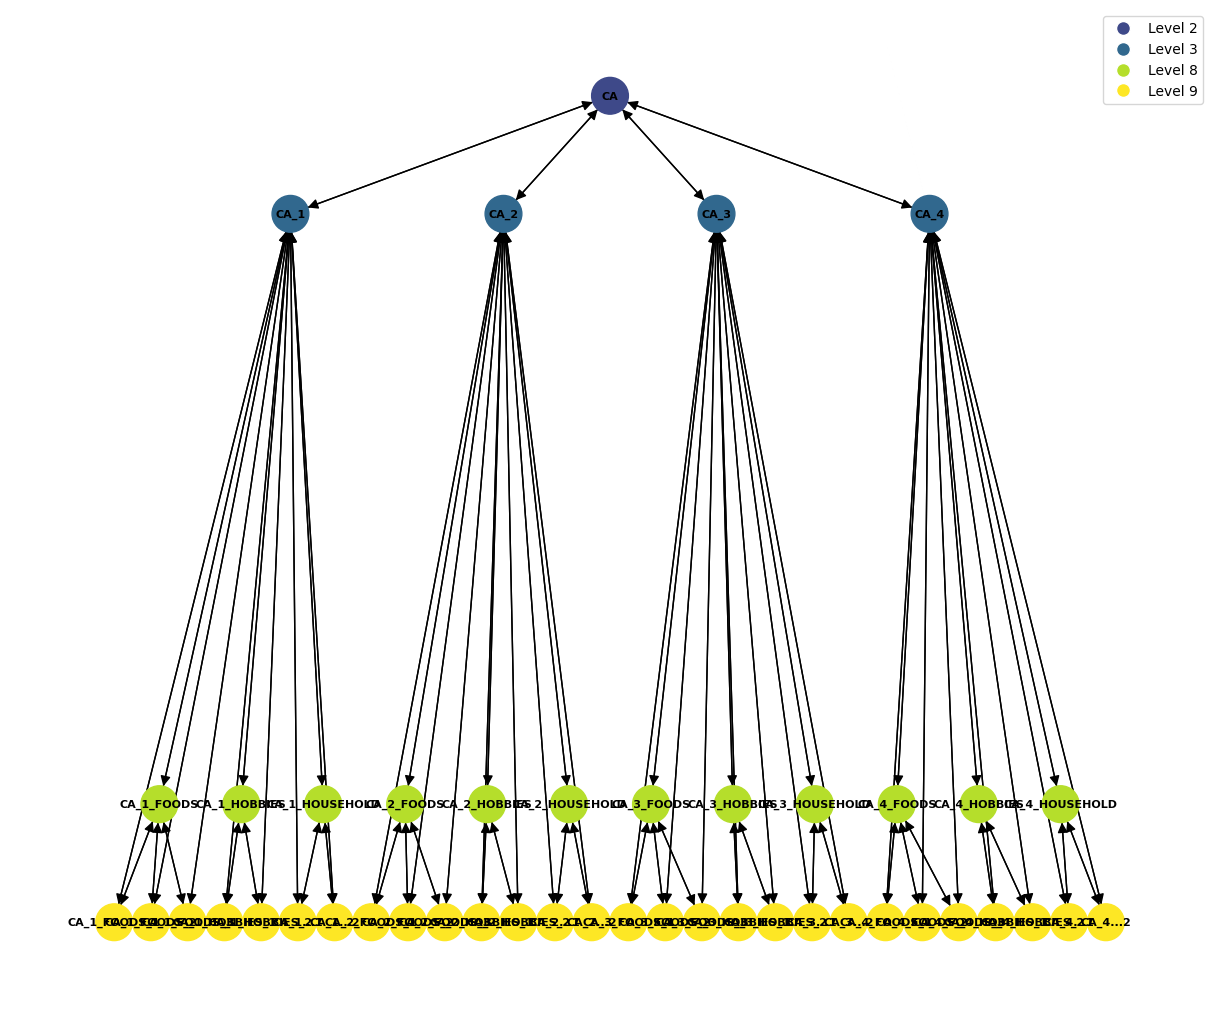

In [6]:
def visualize_hierarchical_subgraph(G, node_list, node_to_idx):
    # 노드 이름을 인덱스로 변환
    node_indices = [node_to_idx[node] for node in node_list if node in node_to_idx]
    
    # 하위 그래프 추출
    subgraph = G.subgraph(node_indices)
    
    plt.figure(figsize=(12, 10))
    
    # 역매핑 생성
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}
    
    # 노드 레벨 정보 추출
    node_levels = {node: G.nodes[node]['level'] for node in subgraph.nodes()}
    
    # 계층별 y좌표 설정 (레벨이 높을수록 위에 배치)
    max_level = max(node_levels.values()) if node_levels else 0
    level_to_y = {level: 1.0 - (level / (max_level + 1)) for level in range(max_level + 1)}
    
    # 수동으로 계층적 레이아웃 생성
    pos = {}
    level_counts = {}  # 각 레벨별 노드 카운트
    
    # 먼저 각 레벨별 노드 수 계산
    for node, level in node_levels.items():
        level_counts[level] = level_counts.get(level, 0) + 1
    
    # 노드 위치 계산
    for node, level in node_levels.items():
        # 현재 레벨에서 이 노드가 몇 번째인지 계산
        if 'node_order' not in level_counts:
            level_counts['node_order'] = {}
        level_counts['node_order'][level] = level_counts['node_order'].get(level, 0) + 1
        node_order = level_counts['node_order'][level]
        
        # x 좌표 계산 (같은 레벨 내에서 균등하게 분포)
        x = node_order / (level_counts[level] + 1)
        y = level_to_y[level]
        
        pos[node] = (x, y)
    
    # 노드 레이블 (긴 이름은 줄임)
    labels = {}
    for node in subgraph.nodes():
        node_name = idx_to_node[node]
        # 노드 이름이 너무 길면 줄임
        if len(node_name) > 15:
            parts = node_name.split('_')
            if len(parts) > 2:
                # 첫 두 부분과 마지막 부분만 표시
                node_name = f"{parts[0]}_{parts[1]}...{parts[-1]}"
        labels[node] = node_name
    
    # 엣지 색상 설정
    edge_colors = []
    for u, v, data in subgraph.edges(data=True):
        if data['direction'] == 'down':
            edge_colors.append('black')
        else:  # 'up'
            edge_colors.append('black')
    
    # 노드 색상 설정 (레벨별로 다른 색상)
    node_colors = []
    color_map = plt.cm.get_cmap('viridis', max_level + 1)
    
    for node in subgraph.nodes():
        level = node_levels[node]
        node_colors.append(color_map(level / max_level))
    
    # 그래프 그리기
    nx.draw(subgraph, pos, with_labels=True, labels=labels, 
            node_size=700, node_color=node_colors, 
            edge_color=edge_colors,
            font_size=8, font_weight='bold', arrows=True,
            arrowsize=15)
    
    # 레벨 범례 추가
    unique_levels = sorted(set(node_levels.values()))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=color_map(level / max_level), 
                                   markersize=10, label=f'Level {level}')
                       for level in unique_levels]
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

subset_nodes = [
    # 'total', 
    'CA', 
    # 'TX', 
    # 'WI', 
    'CA_1', 
    'CA_2', 
    'CA_3',
    'CA_4',
    'CA_1_FOODS', 
    'CA_1_HOBBIES',
    'CA_1_HOUSEHOLD',
    'CA_2_FOODS',
    'CA_2_HOBBIES',
    'CA_2_HOUSEHOLD',
    'CA_3_FOODS',
    'CA_3_HOBBIES',
    'CA_3_HOUSEHOLD',
    'CA_4_FOODS',
    'CA_4_HOBBIES',
    'CA_4_HOUSEHOLD',
    'CA_1_FOODS_1',
    'CA_1_FOODS_2',
    'CA_1_FOODS_3',
    'CA_1_HOBBIES_1',
    'CA_1_HOBBIES_2',
    'CA_1_HOUSEHOLD_1',
    'CA_1_HOUSEHOLD_2',
    'CA_2_FOODS_1',
    'CA_2_FOODS_2',
    'CA_2_FOODS_3',
    'CA_2_HOBBIES_1',
    'CA_2_HOBBIES_2',
    'CA_2_HOUSEHOLD_1',
    'CA_2_HOUSEHOLD_2',
    'CA_3_FOODS_1',
    'CA_3_FOODS_2',
    'CA_3_FOODS_3',
    'CA_3_HOBBIES_1',
    'CA_3_HOBBIES_2',
    'CA_3_HOUSEHOLD_1',
    'CA_3_HOUSEHOLD_2',
    'CA_4_FOODS_1',
    'CA_4_FOODS_2',
    'CA_4_FOODS_3',
    'CA_4_HOBBIES_1',
    'CA_4_HOBBIES_2',
    'CA_4_HOUSEHOLD_1',
    'CA_4_HOUSEHOLD_2'
]
visualize_hierarchical_subgraph(G, subset_nodes, node_to_idx)

In [7]:
edge_idx = []
edge_type = []

for u, v, data in G.edges(data=True):
    edge_idx.append([u, v])
        
    if data['type'] == 'geo_hierarchy':
        type_idx = 0
    elif data['type'] == 'prod_hierarchy':
        type_idx = 1
    elif data['type'] == 'agg_hierarchy':
        type_idx = 2
    elif data['type'] == 'cross_hierarchy':
        type_idx = 3
    edge_type.append(type_idx)

edge_idx = torch.tensor(edge_idx, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(edge_type, dtype=torch.long)

x = []
for i in range(len(G.nodes())):
    x.append(idx_to_forecast[i])
x = torch.stack(x)

# PyG Data 객체
pyg_data = Data(x=x, edge_index=edge_idx, edge_type=edge_type)
pyg_data.num_nodes = len(G.nodes())
pyg_data.num_edge_types = len(set(edge_type.numpy().tolist()))

torch.save(pyg_data, '../dataset/graph/pyg_data.pt')